In [16]:
#%matplotlib notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

from scipy.stats import norm
from scipy.stats import t
from scipy.stats import chi2

from scipy import integrate

import os
import os.path as path
import wget

from tqdm import tqdm
import corner

In [2]:
sample = np.array([0.974,0.950,0.932,1.104,1.038,0.920,0.935,0.907,0.810,0.915])

In [3]:
np.mean(sample)

0.9484999999999999

In [4]:
def Resample(sample):
    
    resample_ = np.random.choice( sample, size=len(sample), replace=True )
    return resample_
    

In [5]:
np.mean(Resample(sample))

0.9522000000000002

In [77]:
def Bootstrapping(sample, N = int(1e5)):
    
    Mean_Dist = np.zeros( N )
    
    for i in tqdm(range(N)):
        resample_ = Resample(sample)
        Mean_Dist[i] = np.mean(resample_)
        
    return Mean_Dist

In [78]:
Mean_Dist = Bootstrapping(sample)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 38519.18it/s]


In [79]:
# Parametros de la distribucion
N = len(Mean_Dist)
xbar = np.mean(sample)
#xbar = np.percentile(Mean_Dist,50)
std = np.std(Mean_Dist)
print(xbar,std)

0.9484999999999999 0.023701395549301396


In [80]:
def Gaussian(x,mu,sigma): # Luego será el Likelihood
    
    return np.exp( -(x-mu)**2/(2*sigma**2) )/np.sqrt(2*np.pi*sigma**2)

In [81]:
x = np.linspace(np.min(sample),np.max(sample),100)
y = Gaussian(x,xbar,std)

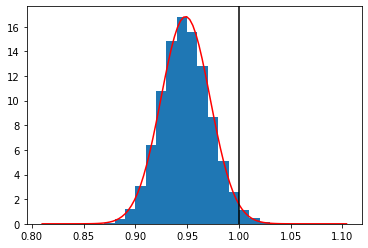

In [82]:
plt.hist(Mean_Dist,bins=np.arange(np.min(sample),np.max(sample),0.01),density=True)
plt.plot(x,y,color='r')
plt.axvline(x=1,color='k')

In [88]:
#probabilidad de obtener usando el modelo de probabilidad
I = integrate.quad(Gaussian,1.,np.inf,args=(xbar,std))[0]
print(I)

0.014895133030927269


In [89]:
# Usando los datos los eventos donde la media es igual o mayor a 1.
datasort = np.sort(Mean_Dist)

ii = np.where( datasort >= 1. )

EventosFavorables = np.sum( datasort[ii] )

frecuencia_relativa = EventosFavorables/N
print(frecuencia_relativa)

0.018243493


In [90]:
if not path.exists('Data'):
    os.mkdir('Data')
    
file = 'Data/Minimos.dat' 

url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/MinimosLineal.txt'
#url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/MinimosCuadratico.txt'

if not path.exists(file):
    Path_ = wget.download(url,file)
else:
    Path_ = file

In [91]:
data = np.loadtxt(Path_)
x = data[:,0]
y = data[:,1]
N = len(x)
sigma = np.random.uniform(0,0.2,N)
sigma
print(N)

20


<ErrorbarContainer object of 3 artists>

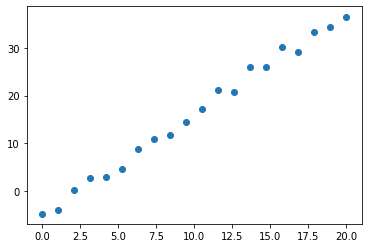

In [92]:
plt.errorbar(x,y,yerr=sigma,fmt='o')

In [93]:
def GetFit(x,y,n=2):
    
    l = x.shape[0]
    b = y
    
    A = np.ones((l,n+1))
    
    for i in range(1,n+1):
        A[:,i] = x**i
        
    AT = np.dot(A.T,A)
    bT = np.dot(A.T,b)
    
    xsol = np.linalg.solve(AT,bT)
    
    return xsol

In [94]:
n = 1
param = GetFit(x,y,n)
param

array([-5.12918553,  2.12503681])

In [95]:
def GetModel(x,p):
    
    y = 0
    for n in range(len(p)):
        y += p[n]*x**n
        
    return y

In [96]:
X = sym.Symbol('x',real=True)
GetModel(X,param)

2.12503680800827*x - 5.12918552885299

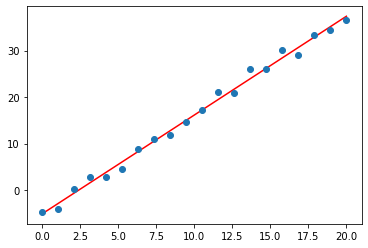

In [97]:
_x = np.linspace(np.min(x),np.max(x),50)

_y = GetModel(_x,param)

plt.errorbar(x,y,yerr=sigma,fmt='o')
plt.plot(_x,_y,color='r')

# Bootstrapping (Bradley Efron 1979)